In [ ]:
from elasticsearch_dsl import Search
from elasticsearch import Elasticsearch

In [ ]:
URL = "178.157.13.134:9200"

In [ ]:
import re
def transform(string):
    string = string.split("'")[0]
    string = string.split("´")[0]
    string = string.split("`")[0]
    string = re.sub("[,./!?()″...‘”’..:''…“\"³`;#|😻+_[]]", "", string)
    string = re.sub("\s+", " ", string)
    string = string.replace("-", "")
    string = string.replace("]", "")
    string = string.replace('\\', "")

    return string.lower()

In [ ]:
string = 'eeuhreuhr"eüeüe"(201)'
string = re.sub("""[,./!?()″...‘”’"..:''…“³`;#|😻+_[]]""", "", string)
string

In [ ]:
from collections import Counter
c = Counter()

In [ ]:
_es = Elasticsearch(URL)
page = _es.search(scroll="2m", size=1000, index="document_news",body={
	"query": {
		"match_all": {}
	}
	,
	"_source": ["title"]
})
scroll_size = page["hits"]["total"]
sid = page["_scroll_id"]


In [ ]:
from collections import defaultdict
d = defaultdict(int)

while scroll_size > 0:
    page = _es.scroll(scroll_id=sid,scroll="2m")
    sid = page["_scroll_id"]
    scroll_size = len(page['hits']['hits'])
    print("scroll size: " + str(scroll_size))
    for title in page["hits"]["hits"]:
        for word in title["_source"]['title'].split(" "):
            d[transform(word)]+=1
        

In [ ]:
trimmed = trim_n_most(d)
print(len(trimmed))
with open("words.csv","w+") as f:
    for word in trimmed:
        f.write(word +"\n")

In [2]:
import matplotlib.pyplot as plot
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from collections import Counter


class Plotter:
	@staticmethod
	def plot_embeddings(words):
		embeds = []
		for word in words:
			try:
				_embed = model.get_embedding(word)
				embeds.append(_embed)
			except:
				continue

		pca_embeds = PCA(n_components=2).fit_transform(embeds)

		plot.scatter(pca_embeds[:,0], pca_embeds[:,1])

		for title, xy in zip(words, pca_embeds):
			plot.annotate(title, xy=(xy[0], xy[1]), xytext=(2, 2), textcoords='offset points')

		x_diff = (pca_embeds[:,0].max() - pca_embeds[:,0].min()) * 0.1
		y_diff = (pca_embeds[:,1].max() - pca_embeds[:,1].min()) * 0.1

		# plot.xlim(x_cords.min() - x_diff, x_cords.max() + x_diff)
		# plot.ylim(y_cords.min() - y_diff, y_cords.max() + y_diff)
		plot.show()

	@staticmethod
	def plot_titles(title_embeddings, titles, n_components=2, tsne=False):
		if tsne:
			tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=1000,random_state=31)
			tsne = tsne.fit_transform(title_embeddings)
		else:
			tsne = PCA(n_components=2)
			tsne = tsne.fit_transform(title_embeddings)
		x_cords = tsne[:, 0]
		y_cords = tsne[:, 1]

		plot.figure(figsize=(40,40))
		plot.scatter(x_cords, y_cords)

		for title, x, y in zip(titles, x_cords, y_cords):
			plot.annotate(title, xy=(x, y), xytext=(2, 2), textcoords='offset points', ha="right", va="bottom")

		x_diff = (x_cords.max() - x_cords.min()) * 0.1
		y_diff = (y_cords.max() - y_cords.min()) * 0.1

		plot.xlim(x_cords.min() - x_diff, x_cords.max() + x_diff)
		plot.ylim(y_cords.min() - y_diff, y_cords.max() + y_diff)
		plot.show()

	@staticmethod
	def plot_histogram(title_dict):
		if isinstance(title_dict, list):
			c = Counter(title_dict)
			titles = list(c.keys())
			values = list(c.values())
		elif isinstance(title_dict, dict):
			titles = list(title_dict.keys())
			values = list(title_dict.values())
		else:
			raise Exception("Wrong class")

		fig = plot.figure()
		ax = fig.add_subplot(111)
		x_cord = np.arange(len(titles))

		ax.bar(x_cord, values, align="center")
		ax.xaxis.set_major_locator(plot.FixedLocator(x_cord))
		ax.xaxis.set_major_formatter(plot.FixedFormatter(titles))

		plot.show()


def get_cmap(n, name='hsv'):
	'''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
	RGB color; the keyword argument name must be a standard mpl colormap name.'''
	return plot.cm.get_cmap(name, n)



In [3]:
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.word2vec import LineSentence


class NLP:
	def __init__(self, model_path="/home/nxull/Projects/teleskop_nlp/teleskop_nlp/nlp/tr_model", model=Word2Vec):
		self.model = model.load(model_path)

	def train_new_words(self, words, epoch=1):
		lc = self._build_vocab(words)
		print("Training new words")
		self.model.train(words, total_examples=lc, epochs=epoch)
		print("Done")

	def _build_vocab(self, words):
		print("Building vocab")
		if isinstance(words, str):
			words = LineSentence(words)
			self.model.build_vocab(words, update=True)
		if not isinstance(words, LineSentence):
			raise Exception("")
		lc = self.count_lines(words.source)
		self.model.build_vocab(words, update=True)
		print("Done")
		return lc

	def get_embedding(self, word):
		try:
			return self.model.wv.get_vector(word)
		except:
			return None

	@staticmethod
	def count_lines(self, file):
		f = open(file, "r")
		lc = 0
		for line in f:
			lc += 1
		return lc


In [4]:
def trim_n_most(counter, n_most=3):
	if isinstance(counter, Counter):
		return [k for k, v in counter.items() if v > n_most]
	elif isinstance(counter, list):
		return [k for k, v in Counter(counter).items() if v > n_most]
	elif isinstance(counter, dict):
		return [k for k, v in counter.items() if v > n_most]

In [5]:
model = NLP()

In [6]:
s = set()
with open("clean_words.csv","r") as f:
    for line in f:
        s.add(line.strip())

In [7]:
not_in_dict = []
_embeds = []
in_dict = []
for word in s:
    e = model.get_embedding(word)
    if e is None:
        not_in_dict.append(word)
    else:
        in_dict.append(word)
        _embeds.append(e)

In [8]:
from sklearn.cluster import KMeans

In [9]:
km = KMeans(n_clusters=30,random_state=0).fit(_embeds)

27876

In [10]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [20]:
km0 = ClusterIndicesNumpy(1,km.labels_)

array([  106,   390,   400,   767,   817,  1039,  1050,  1068,  1295,
        1326,  1352,  1364,  1443,  1492,  1782,  1812,  1988,  2466,
        2512,  2604,  2653,  2715,  2778,  2817,  2952,  3160,  3253,
        3713,  3728,  3800,  3896,  3916,  3918,  3935,  3937,  4237,
        4253,  4331,  4366,  4466,  4637,  4770,  4812,  4871,  4911,
        4955,  5009,  5019,  5184,  5310,  5475,  5568,  5606,  5677,
        5719,  5823,  6099,  6745,  6815,  6868,  6971,  7124,  7131,
        7171,  7749,  7922,  7995,  8007,  8200,  8223,  8364,  8704,
        9249,  9509,  9557,  9617,  9721,  9828, 10056, 10057, 10095,
       10123, 10133, 10190, 10409, 10513, 10674, 10746, 11100, 11213,
       11308, 11350, 11402, 11588, 12033, 12038, 12159, 12399, 12461,
       12495, 12626, 12635, 12676, 13112, 13183, 13356, 13417, 13444,
       13529, 13815, 13847, 14083, 14188, 14345, 14882, 15251, 15298,
       15356, 15923, 16067, 16140, 16264, 16283, 16311, 16438, 16507,
       16849, 17024,

In [24]:
vs = np.vstack(_embeds)

In [25]:
vs[km0]

array([[ 0.374049  ,  0.45599738, -0.00512662, ..., -0.00286105,
         0.06155467, -0.05560023],
       [ 1.4927769 ,  0.24536766,  0.5363273 , ..., -0.26429966,
        -0.38057718, -0.07076127],
       [ 0.48117757, -2.2860937 ,  0.29434574, ..., -0.48917556,
         0.7202205 , -0.31255385],
       ...,
       [ 0.7433983 , -0.18594538, -1.0213827 , ..., -0.1690369 ,
         0.19491097, -0.02181096],
       [ 1.2459822 ,  0.39417833, -0.09280136, ...,  1.5878177 ,
        -0.66304713,  0.3767989 ],
       [ 0.95805866,  0.56648076,  0.33346874, ..., -0.2739599 ,
         0.7091321 , -0.20651615]], dtype=float32)

In [13]:
%matplotlib qt

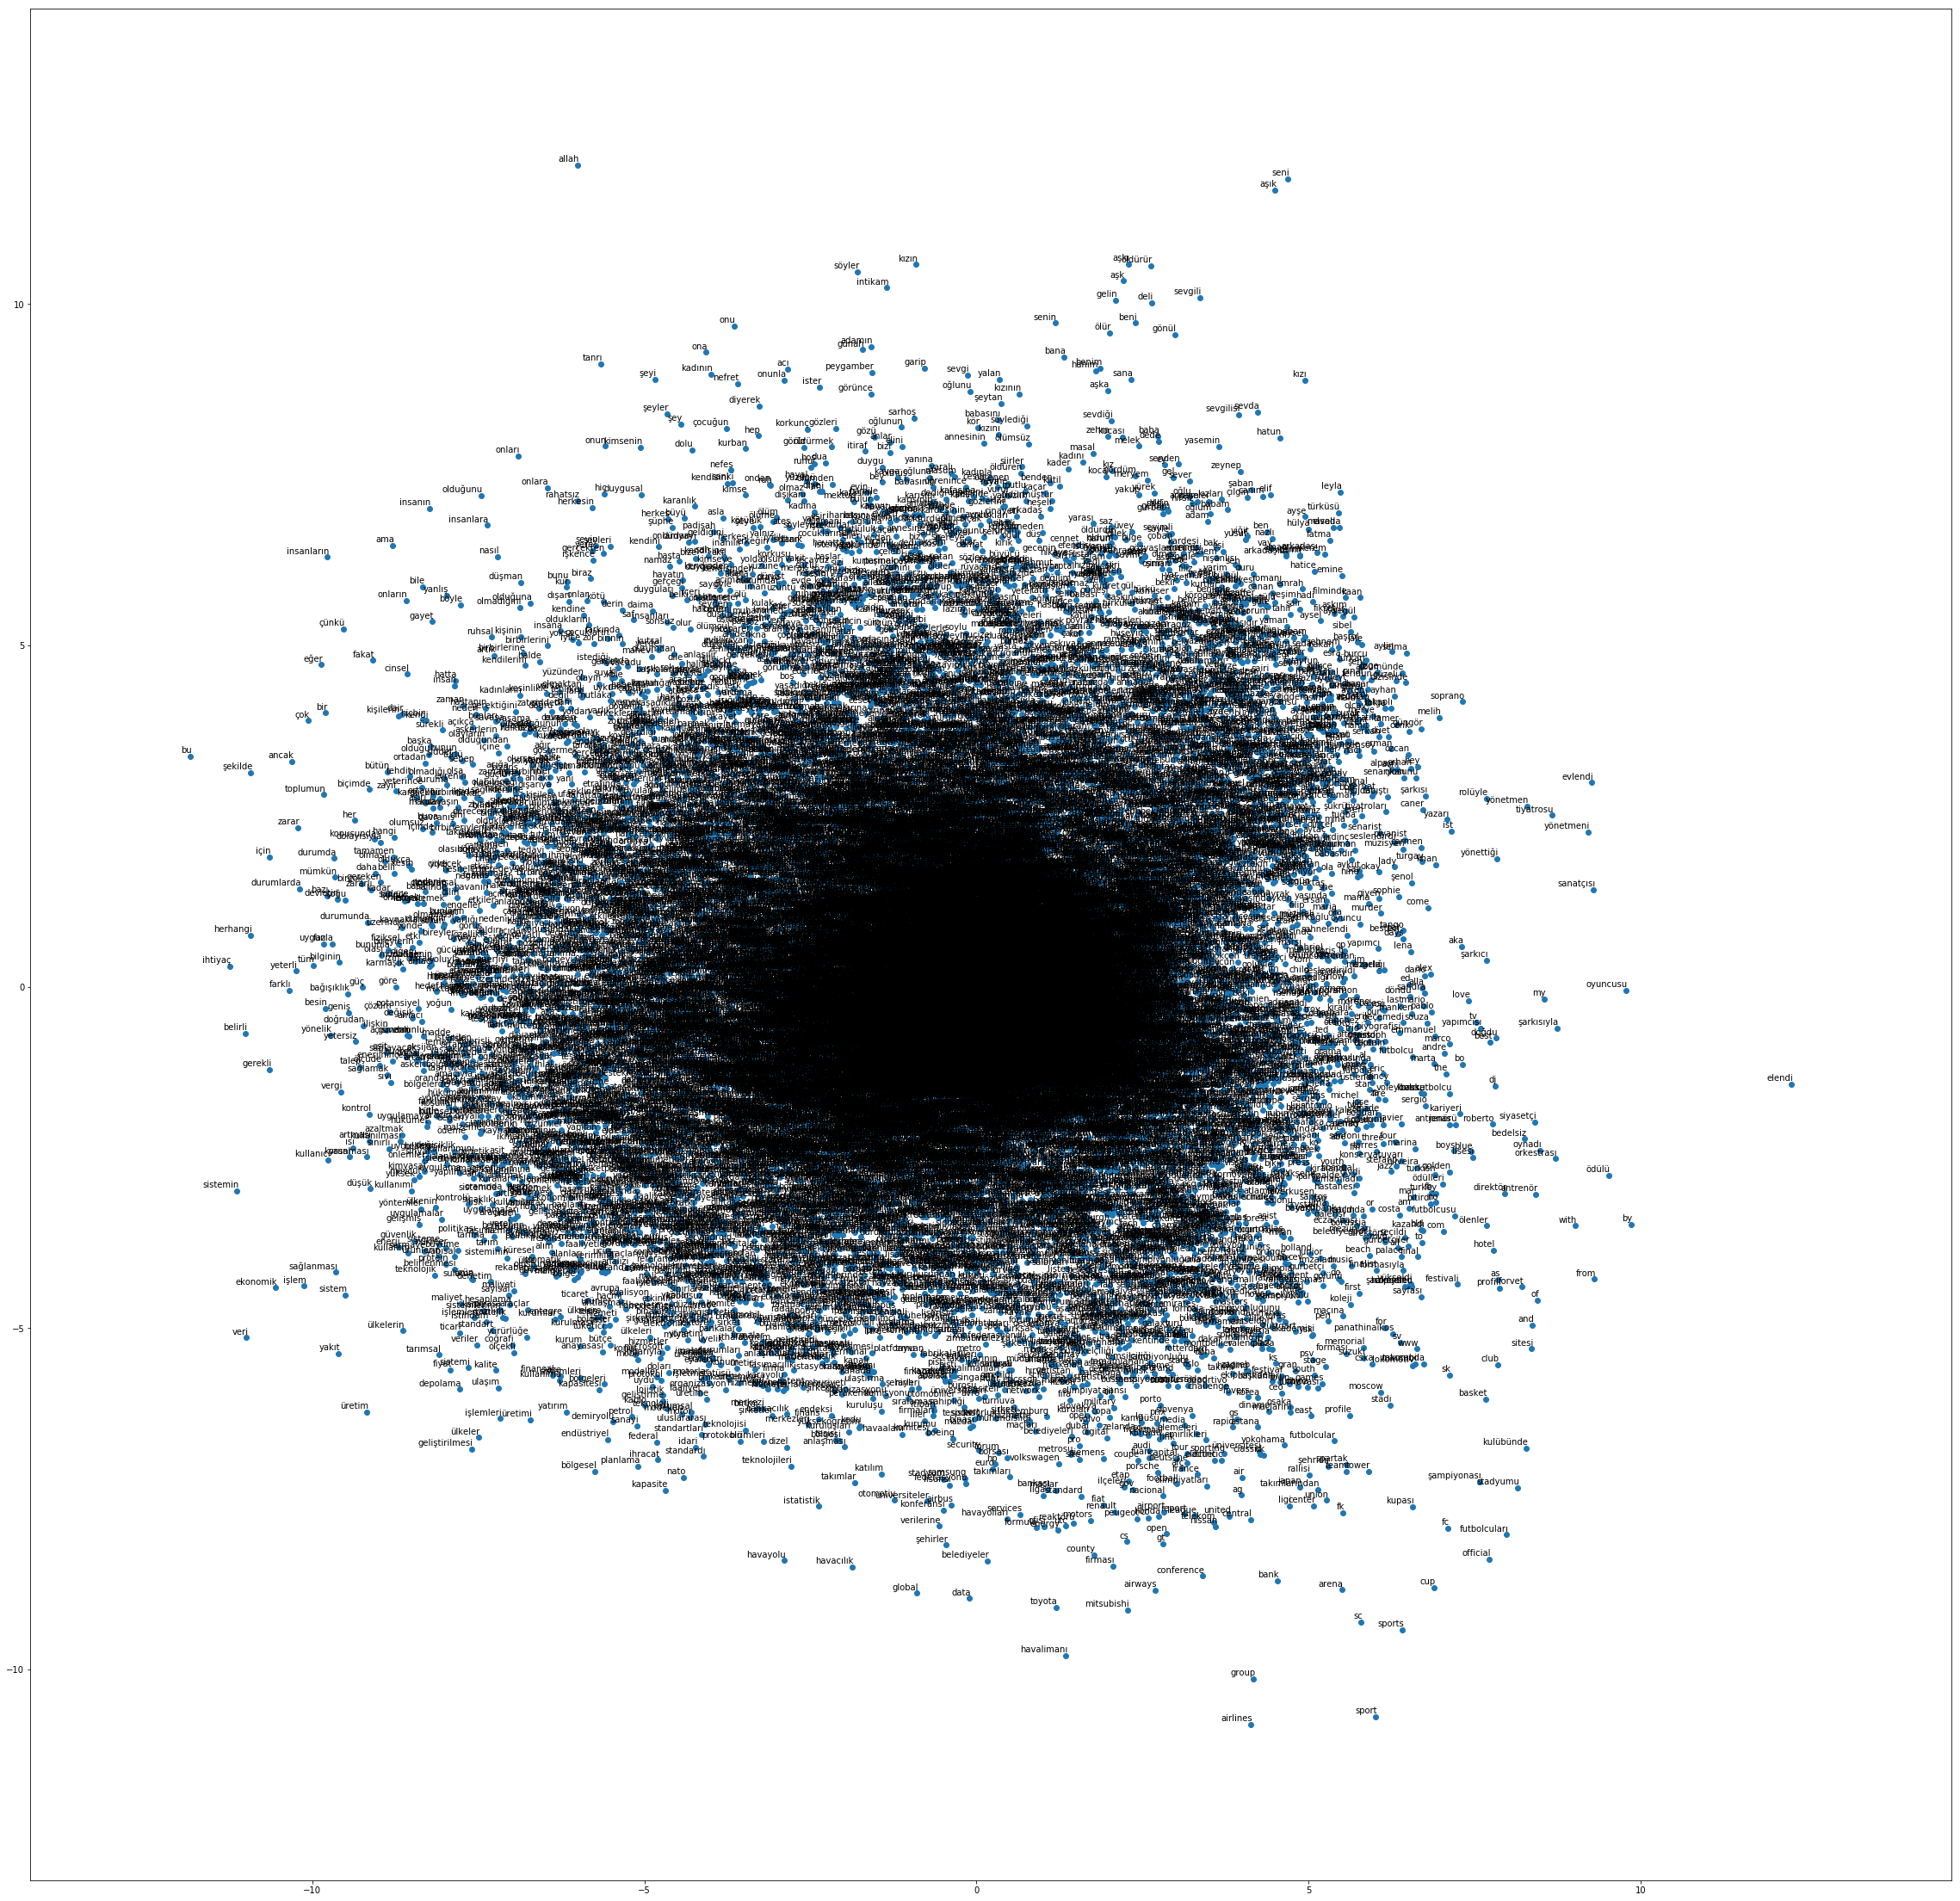

In [26]:
Plotter.plot_titles(vs,in_dict,True)

In [ ]:
plot.savefig("embeds",dpi=1200)

In [ ]:
with open("not_in_dict.csv","w") as f:
    for word in not_in_dict:
        f.write(word+"\n")


In [ ]:
"ilgi" in in_dict

In [ ]:
for word in trimmed:
    print(word)